In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz
import numpy as np


In [49]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

conda install -c anaconda python-graphviz

conda install -c anaconda pydot

In [2]:
giocatori = pd.read_csv('dataset\giocatori.csv')

giocatori = giocatori.drop('nome_giocatore', axis = 1)
giocatori = giocatori.drop('numero_giocatore', axis = 1)
giocatori = giocatori.drop('squadra', axis = 1)
giocatori = giocatori.drop('RIM_D', axis = 1)
giocatori = giocatori.drop('RIM_O', axis = 1)
giocatori = giocatori.drop('T1_PER', axis = 1)
giocatori = giocatori.drop('T2_PER', axis = 1)
giocatori = giocatori.drop('T3_PER', axis = 1)

players_without_role = giocatori.loc[(giocatori["ruolo"].isnull()) | (giocatori["ruolo"] == "NaN")]
players_without_role = players_without_role.drop('ruolo', axis = 1)

giocatori = giocatori.dropna();

# Definire una funzione per scalare i valori di ogni riga
def scale_cols(df, col):
    df = df[df[col] != 0]
    factor = 40/df[col].values
    float_cols = df.select_dtypes(include=['float64']).columns
    float_cols = float_cols.drop(col)
    df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
    return df

players_without_role = scale_cols(players_without_role, 'minuti')
players_without_role = players_without_role.drop('minuti', axis = 1)
players_without_role["altezza"] = players_without_role["altezza"].replace(0, np.nan, inplace=True)

giocatori = scale_cols(giocatori, 'minuti')
giocatori = giocatori.drop('minuti', axis = 1)

C:\Users\nicol\AppData\Local\Temp\ipykernel_27244\1143009646.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
C:\Users\nicol\AppData\Local\Temp\ipykernel_27244\1143009646.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)


In [3]:
x = giocatori.drop('ruolo', axis=1)
y = giocatori['ruolo']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=100)

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 9,11,None],
              'min_samples_split': [2, 10, 30, 50]}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(x, y)
clf = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)
print("Best score: %0.2f" % grid_search.best_score_)

Best parameters found:  {'max_depth': 3, 'min_samples_split': 2}
Best score: 0.68


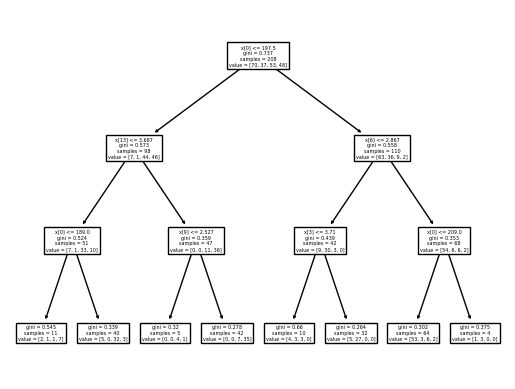

In [5]:
tree.plot_tree(clf)
plt.show()

In [6]:
#Esportazione albero di decisione
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("ruoli_tree")

'ruoli_tree.pdf'

In [7]:
#Quasto modello non può lavorare con valori nulli. Dunque si scarta in caso si abbiano giocatori con valori nulli.
#y_pred = grid_search.predict(players_without_role)
#print(players_without_role.values)
#print(y_pred)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import datasets

HGBC = HistGradientBoostingClassifier(max_iter=150, learning_rate=0.1)
HGBC.fit(x, y)

scores = cross_val_score(HGBC, x, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.64 (+/- 0.05)


In [9]:
y_pred = HGBC.predict(players_without_role)
print(y_pred)


['Ala' 'Guardia' 'Ala' 'Guardia' 'Guardia' 'Ala' 'Play' 'Ala' 'Ala' 'Play'
 'Play' 'Play' 'Ala' 'Play' 'Ala' 'Play' 'Guardia' 'Guardia' 'Centro'
 'Play' 'Ala' 'Play' 'Guardia' 'Guardia' 'Guardia' 'Guardia' 'Ala' 'Ala'
 'Ala' 'Play' 'Ala' 'Guardia']


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Define a range of values to test for max_depth
max_depth_values = [2, 4, 6, 8, 10]

# Define a range of values to test for random_state
random_state_values = [0, 4, 16, 64, 256, 1024,4096]

# Store the mean cross-validation scores for each combination of max_depth and random_state
scores = []
for max_depth in max_depth_values:
    for random_state in random_state_values:
        RFC = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
        cv_scores = cross_val_score(RFC, x, y, cv=5)
        scores.append((max_depth, random_state, cv_scores.mean()))

# Convert the scores list to a numpy array
scores = np.array(scores)

# Get the index of the maximum score
best_index = np.argmax(scores[:,2])

# Get the best max_depth and random_state values
best_max_depth = scores[best_index, 0]
best_random_state = scores[best_index, 1]

# Print the best max_depth and random_state values
print("Best max_depth value: {}".format(best_max_depth))
print("Best random_state value: {}".format(best_random_state))

RFC = RandomForestClassifier(max_depth=int(best_max_depth), random_state=int(best_random_state))
RFC.fit(x, y)
scores = cross_val_score(RFC, x, y, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Best max_depth value: 2.0
Best random_state value: 16.0
Cross-validation scores: [0.78571429 0.71428571 0.76190476 0.70731707 0.56097561]
Average cross-validation score: 0.71 +/- 0.08


In [11]:
#Non funziona con valori nulli
#y_pred = RFC.predict(players_without_role)
#print(y_pred)

In [12]:
from sklearn.metrics import accuracy_score
# Predict the labels of the test data
y_pred = RFC.predict(x_test)

# Calculate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 76.19%


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#Se non scalo la x non converge.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scal = scaler.fit_transform(x)
#########
LR = LogisticRegression(max_iter=1000)
LR.fit(x_scal, y)

scores = cross_val_score(LR, x_scal, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.08)


In [38]:
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Effettua la codifica one-hot, rende y un vettore [0,0,0,0]
le = LabelEncoder()
y = le.fit_transform(y)
Y = to_categorical(y)

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

def create_model(neurons_first_layer, neurons_second_layer):
    model = Sequential()
    model.add(Dense(neurons_first_layer, activation='relu', input_shape=(15,)))
    model.add(Dense(neurons_second_layer, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=32, verbose=0)

neurons_first_layer = [32, 64, 128]
neurons_second_layer = [16, 32, 64]
param_grid = dict(neurons_first_layer=neurons_first_layer, neurons_second_layer=neurons_second_layer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x, Y)

# Stampa dei risultati
print("Migliori parametri: ", grid_result.best_params_)
print("Miglior punteggio: ", grid_result.best_score_)

C:\Users\nicol\AppData\Local\Temp\ipykernel_27244\4043873736.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=32, verbose=0)


Migliori parametri:  {'neurons_first_layer': 32, 'neurons_second_layer': 32}
Miglior punteggio:  0.6536585330963135


In [47]:
print('Accuratezza: %.2f' % (grid.score(x, Y)*100))
#print('Accuratezza: %.2f' % (accuracy*100))

Accuratezza: 83.17


In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
prova = imputer.fit_transform(players_without_role)
y_pred = grid.predict(players_without_role)
def predizione(pred):
    strings = ["Ala", "Play", "Centro", "Guardia"]
    return [strings[np.argmax(vector)] for vector in pred]

print(predizione(y_pred))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type NoneType).